In [1]:
import os, sys, inspect
import json
import decimal
current_dir = os.path.dirname(os.path.abspath(os.path.join(inspect.getfile(inspect.currentframe()), os.pardir)))
current_dir = os.path.join(current_dir ,"src")
sys.path.insert(0, current_dir)

import analyser
import cv2
import matplotlib.pyplot as plt
import color_analyser as ca
import analyser
import feature_extractor as fe
path_data = os.path.join("..","input")

plt.rcParams['figure.figsize'] = [25, 25]

# Pipeline

This document shows the pipeline and result of the project.

For each photo following steps are performed:

1. Decides whether image is a photo or not. (photos are immediately discarded from feature processing.)
2. Split picture to layers according to its color composition (see `Color` notebook)
3. Identifies features
  1. Lines (see `Lines` notebook)
  2. Text (see `Text` notebook)
4. Put features togehter and print results



## Photo filtering

Given two pictures. One with panda close-up and the second with a two linear functions. We will filter out the functions.

The decision is based on histogram analysis. Pictures with function are presumed to have significatn percentage of a solid background.

In [2]:
pics = ["artifical_text.png","panda.JPG"]

for pic_name,pic_path in [ (p, os.path.join(path_data,p)) for p in pics  ]:
    img = cv2.imread(pic_path)
    if analyser.is_photo(img):
        print("{} is a photo".format(pic_name))
    else :
        print("{} is NOT a photo".format(pic_name))

artifical_text.png is NOT a photo
panda.JPG is a photo


## Split image to layers

The image is coverted to gray-scale and the most significant colors are extracted according to methods described in `Color` notebook. 

The number of color is then fed to k-means algorithm which then assign each pixel is center and separate it to its layer. White color represent the layer pixels and black is everything else. Beware, when background layer is extracted, then everything representing background is white.

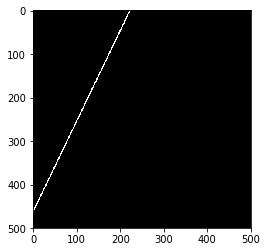

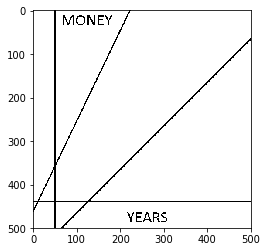

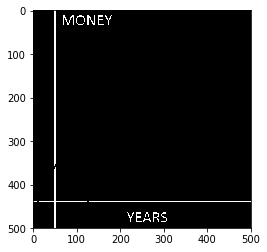

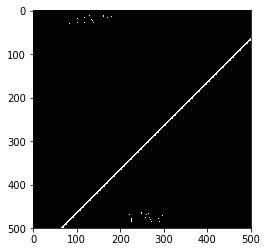

In [3]:
pic_path = os.path.join(path_data,"artifical_text.png")
img = cv2.imread(pic_path)
k = ca.get_color_count(img)
layers = fe.split_to_k_layers(img, k)
for layer in layers:
    plt.imshow(layer,cmap ="gray")
    plt.show()

## Feature extraction

Extracts lines and text

Lines are extracted using Hough transformation. It need to be configured before first use.
The text detection is performed using pre-made neural network. (see `Text` notebook)


layer 1
texts: ['4 way a', 'MONEY']
lines: [array([50.,  0.], dtype=float32), array([439.       ,   1.5707964], dtype=float32)]


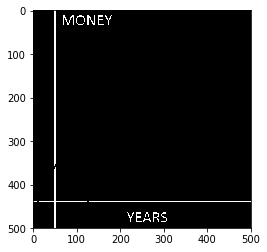

layer 2
texts: []
lines: [array([201.       ,   0.4537856], dtype=float32)]


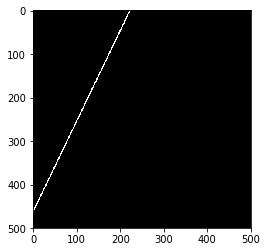

layer 3
texts: ['Jo sp oy']
lines: [array([400.       ,   0.7853982], dtype=float32)]


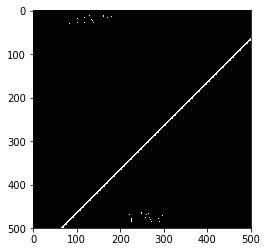

layer 4
texts: ['VYFARS', 'MONEY']
lines: []


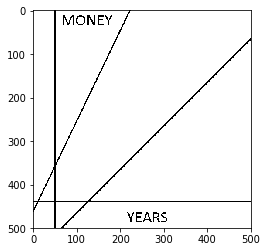

In [4]:
cfg = {"hough_transform_minLineLength": 100,
       "hough_transform_maxLineGap": 10,
       "hough_transform_filter_threshold_distance": 10,
       "hough_transform_filter_threshold_angle": 3
      }
network_path = os.path.join("config", "frozen_east_text_detection.pb")
net = cv2.dnn.readNet(os.path.join( "..",network_path) )
pic_path = os.path.join(path_data,"artifical_text.png")
img = cv2.imread(pic_path)

for i,(layer,text,lines) in enumerate(fe.extract_image_features(img,cfg,net )):
    print("layer {}".format(i+1))
    print("texts: {}".format([ t for c,t in text]))
    print("lines: {}".format( lines))
    plt.imshow(layer,cmap="gray")
    plt.show()


## Layer features analysed

Layer features are further analysed. 
- Ortogonal lines are interpreted as axes (see `Lines` notebook for more details)
- Nearest text is presumed to be labels


layer 1
layer has no axes
keywords: ['Jo sp oy']
1 function(s) found
	angle: 0.7853981852531433


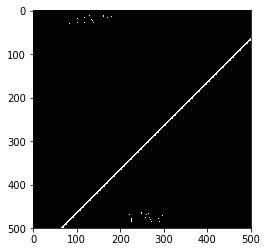

layer 2
Layer is background, analysed data might be corrupted
layer 3
layer has no axes
layer has no text
1 function(s) found
	angle: 0.45378559827804565


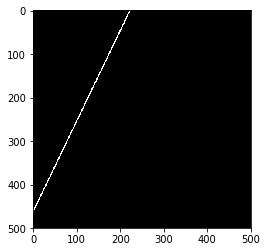

layer 4
axes: {'y': {'label': '16.0', 'position': (50, 0)}, 'x': {'label': '162.0', 'position': (0, 439)}}
keywords: ['4 way a', 'MONEY']
2 function(s) found
	angle: 0.0
	angle: 1.5707963705062866


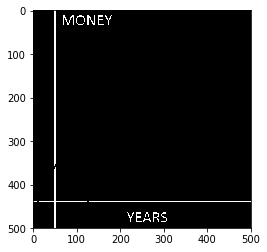

In [5]:
cfg = {"hough_transform_minLineLength": 100,
       "hough_transform_maxLineGap": 10,
       "hough_transform_filter_threshold_distance": 10,
       "hough_transform_filter_threshold_angle": 3
      }
network_path = os.path.join("..","config", "frozen_east_text_detection.pb")
pic_path = os.path.join(path_data,"artifical_text.png")
net = cv2.dnn.readNet(network_path )
img = cv2.imread(pic_path)

for i, data in enumerate(analyser.extract_and_analyse(img,cfg,net)):
    print("layer {}".format(i+1))
    
    if data.get("is_background",False):
        print("Layer is background, analysed data might be corrupted")
        continue
        
    
    if "axes_data" in data and len(data["axes_data"])>0:
        print("axes: {}".format(data["axes_data"]))
    else:
        print("layer has no axes")
    
    if "keywords" in data and len(data["keywords"])>0:
        print("keywords: {}".format(data["keywords"]))
    else:
        print("layer has no text")
    
    fn_data =data.get("function_data",[]) 
    if len(fn_data)>0:
        print("{} function(s) found".format(len(fn_data)))
        for fn in fn_data:
            print("\tangle: {}".format(fn["angle_rad"]))
    else:
        print("layer has no text")
    
    plt.imshow(data["layer"],cmap="gray")
    plt.show()

## Put layer info together

Collect data layers and make a union

In [6]:
cfg = {"hough_transform_minLineLength": 100,
       "hough_transform_maxLineGap": 10,
       "hough_transform_filter_threshold_distance": 10,
       "hough_transform_filter_threshold_angle": 3
      }
network_path = os.path.join("..","config", "frozen_east_text_detection.pb")
pic_path = os.path.join(path_data,"artifical_text.png")
img = cv2.imread(pic_path)

data = analyser.analyse_image(img,cfg,network_path)

print(json.dumps(data, indent=4, sort_keys=True))

{'axes': {'y': {'label': '16.0', 'position': (50, 0)}, 'x': {'label': '162.0', 'position': (0, 439)}}, 'keywords': ['Jo sp oy', '4 way a', 'MONEY'], 'functions': [{'id': 0, 'angle_rad': 0.0}, {'id': 1, 'angle_rad': 1.5707963705062866}, {'id': 0, 'angle_rad': 0.7853981852531433}, {'id': 0, 'angle_rad': 0.45378559827804565}]}
{
    "axes": {
        "x": {
            "label": "162.0",
            "position": [
                0,
                439
            ]
        },
        "y": {
            "label": "16.0",
            "position": [
                50,
                0
            ]
        }
    },
    "functions": [
        {
            "angle_rad": 0.0,
            "id": 0
        },
        {
            "angle_rad": 1.5707963705062866,
            "id": 1
        },
        {
            "angle_rad": 0.7853981852531433,
            "id": 0
        },
        {
            "angle_rad": 0.45378559827804565,
            "id": 0
        }
    ],
    "keywords": [
        "Jo